In [35]:

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('arabic'))
from bs4 import BeautifulSoup
#import plotly.graph_objs as go
#import plotly.plotly as py
#import cufflinks
#from IPython.core.interactiveshell import InteractiveShell
#import plotly.figure_factory as ff
#InteractiveShell.ast_node_interactivity = 'all'
#from plotly.offline import iplot
#cufflinks.go_offline()
#cufflinks.set_config_file(world_readable=True, theme='pearl')

In [24]:
#readind and preparing data ( text , label )
import os, sys
import pandas as pd
import numpy as np
df=pd.read_excel('ML1.xlsx', header=None) ## read le file
df.columns=['tags','post']
print(df[1:5])

   tags                                               post
1     3  محضر تحقيق بادعاء المدعوة اسما هدى انيس قساطلي...
2     4  محضر تحقيق بحق المدعو ماهر صالح الحرامي سوري ل...
3     1  محضر بتنفيذ خلاصة حكم بحق المدعو محمد سعد الدي...
4     2  محضر بتنفيذ قرار جزائي بحق المدعو محمد سعد الد...


In [43]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9ا-ي #+_]')
STOPWORDS = set(stopwords.words('arabic'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    #text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['post'] = df['post'].apply(clean_text)

In [47]:
print(STOPWORDS)

{'ذواتي', 'كلما', 'بهن', 'إي', 'متى', 'لها', 'هاتان', 'منه', 'أو', 'آها', 'حين', 'منها', 'هذان', 'لك', 'هي', 'إذ', 'هيت', 'لدى', 'غير', 'لاسيما', 'هناك', 'هاك', 'ذلكما', 'يا', 'هذين', 'عما', 'هكذا', 'بكم', 'وإن', 'اللاتي', 'بماذا', 'إليك', 'أقل', 'فمن', 'لكي', 'بيد', 'ثم', 'ذات', 'بما', 'عليك', 'عليه', 'أنتن', 'ذي', 'ثمة', 'لسنا', 'شتان', 'بنا', 'كي', 'لكما', 'ليس', 'ممن', 'هاتي', 'عل', 'كلاهما', 'اللتان', 'هلا', 'وهو', 'إما', 'ذاك', 'كأنما', 'كذا', 'لنا', 'لئن', 'بخ', 'اللتين', 'هؤلاء', 'وإذ', 'فإن', 'إيه', 'هذا', 'إذما', 'أي', 'بل', 'حاشا', 'حتى', 'حيث', 'لكم', 'إذا', 'مع', 'لهن', 'مه', 'كأن', 'سوف', 'إنما', 'ليت', 'بها', 'ماذا', 'هيهات', 'بك', 'ذواتا', 'ألا', 'ذو', 'هاته', 'أنا', 'أولاء', 'ولكن', 'لستم', 'اللذان', 'ذلكم', 'ومن', 'وإذا', 'عند', 'به', 'كليهما', 'لم', 'ليسا', 'ذه', 'أولئك', 'ذا', 'لا', 'نحن', 'ليست', 'كيف', 'كلتا', 'أوه', 'حبذا', 'إلا', 'الذي', 'سوى', 'وما', 'آي', 'اللائي', 'كم', 'بهم', 'هذي', 'لوما', 'أنتم', 'نعم', 'أف', 'أكثر', 'هاهنا', 'ذينك', 'إلى', 'أين', 'في', 'ك

In [50]:
print((BAD_SYMBOLS_RE).sub('','djshin ainjk لم اذهب أليس'))

  لم اذهب ليس


In [44]:
print(df['post'][1:5])

1    محضر تحقيق بادعا المدعوة اسما هدى انيس قساطلي ...
2    محضر تحقيق بحق المدعو ماهر صالح الحرامي سوري ل...
3    محضر بتنفيذ خلاصة حكم بحق المدعو محمد سعد الدي...
4    محضر بتنفيذ قرار جزاي بحق المدعو محمد سعد الدي...
Name: post, dtype: object


In [30]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['post'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 4593 unique tokens.


In [31]:
X = tokenizer.texts_to_sequences(df['post'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1979, 250)


In [32]:
Y = pd.get_dummies(df['tags']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1979, 5)


In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1781, 250) (1781, 5)
(198, 250) (198, 5)


In [38]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 5,080,905
Trainable params: 5,080,905
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Instructions for updating:
Use tf.cast instead.
Train on 1602 samples, validate on 179 samples
Epoch 1/5
1602/1602 [==============================] - 11s 7ms/step - loss: 1.4672 - acc: 0.4757 - val_loss: 1.1980 - val_acc: 0.6201
Epoch 2/5
1602/1602 [==============================] - 9s 5ms/step - loss: 0.8543 - acc: 0.6785 - val_loss: 0.6034 - val_acc: 0.6927
Epoch 3/5
1602/1602 [==============================] - 9s 6ms/step - loss: 0.4752 - acc: 0.7809 - val_loss: 0.4627 - val_acc: 0.8436
Epoch 4/5
1602/1602 [==============================] - 9s 6ms/step - loss: 0.3283 - acc: 0.8770 - val_loss: 0.3835 - val_acc: 0.8603
Epoch 5/5
1602/1602 [==============================] - 9s 6ms/step - loss: 0.2335 - acc: 0.9220 - val_loss: 0.3216 - val_acc: 0.9162


In [40]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

198/198 [==============================] - 0s 2ms/step
Test set
  Loss: 0.193
  Accuracy: 0.960


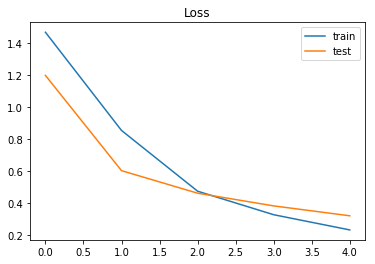

In [51]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

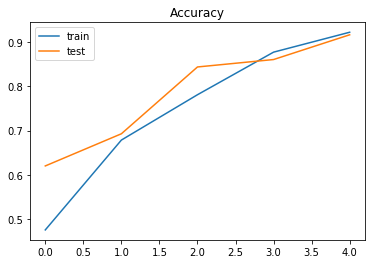

In [52]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();